# Overview
This is my attempt to solve the first assignment of the Signals and Systems course offered by Innopolis University

# Part 1
## Solution's idea
Given a basic function (signal) $f$, we would like to find alpha the a given signal $s(t)$ using fuction $f$. Here is the approach I considered: 
1. First use the discrete Fourier Transform to extract the frequency components in the signal $s(t)$
2. Consider the $K$ frequencies corresponding to the top $K$ peaks in the spectrum: $fr_1, fr_2, .... fr_{k}$
3. consider a number of timestamps $T$
4. Denoting the $f(fr, t_i)$ as the value of the signal $f$ given the frequency $fr$ at the timestamp $t_i$, we consider the matrix $F$: 

$\begin{align} 
\begin{bmatrix}
f(fr_1, t_1) & f(fr_2, t_1) & f(fr_3, t_1) ... & f(fr_k, t_1) \\
f(fr_1, t_2) & f(fr_2, t_2) & f(fr_3, t_2) ... & f(fr_k, t_2) \\
f(fr_1, t_3) & f(fr_2, t_3) & f(fr_3, t_3) ... & f(fr_k, t_3) \\
f(fr_1, t_4) & f(fr_2, t_4) & f(fr_3, t_4) ... & f(fr_k, t_4) \\
..  & .. &  .. & .. \\
f(fr_1, t_T) & f(fr_2, t_T) & f(fr_3, t_T) ... & f(fr_k, t_T)
\end{bmatrix}
\end{align}$
The main part of the approximation is to find the coefficients $\alpha_1, \alpha_2 ... \alpha_k$ minimizing the loss:
$
\begin{align}
\sum_ {j = 1}^{T} (\sum _ {i=1}^{k} \alpha_i \cdot f(fr_i, t_j) - s(t_j)) ^ 2
\end{align}
$

This combination is the least squares solution for the equation expressed in matrix form:
$\begin{align} 
F \cdot \alpha = T
\end{align}
$
where 
$\begin{aligned}
\alpha = \begin{bmatrix}
\alpha_1 \\ 
\alpha_2 \\ 
.. \\
.. \\
\alpha_k
\end{bmatrix}
\end{aligned}
$
and 
$\begin{aligned}
T = \begin{bmatrix}
s(t_1) \\
s(t_2) \\
.. \\
.. \\
s(t_k)
\end{bmatrix}
\end{aligned}$


## extending to multiple signals
Using the same principle, we can make the solution consider multiple signals at once. Assuming we have $m$ basic signals $f_1, f_2 ..., f_m$, we denote $s_i(t)$ as the approximation of function $s(t)$ by $f_i$. We can take the best of each function by finding the best linear combination: $\beta_1, \beta_2... \beta_m$ for the equation:
$\begin{align} 
s(t) = \sum_{i=1}^m \beta_i \cdot s_i(t)
\end{align}$
which is in matrix form expressed as: 
$\begin{align} 
s(t) = S \cdot \beta
\end{align}$
where 
$\begin{aligned}
\beta = \begin{bmatrix}
\beta_1 \\ 
\beta_2 \\ 
.. \\
.. \\
\beta_m
\end{bmatrix}
\end{aligned}
$
and 
$\begin{aligned}
S = \begin{bmatrix}
s_1(t_1) && s_2(t_1) && .. && s_m(t1) \\
s_1(t_2) && s_2(t_2) && .. && s_m(t2) \\
.. \\
.. \\
s_1(t_k) && s_2(t_k) && .. && s_m(tk) \\
\end{bmatrix}
\end{aligned}$


In [8]:
from thinkdsp import Wave 
from thinkdsp import Signal
import numpy as np
from thinkdsp import read_wave
from copy import copy
import random
from random import sample
from thinkdsp import SinSignal, CosSignal, SquareSignal, SumSignal, TriangleSignal, SawtoothSignal

# let's set the random module seed for reproducibility
np.random.seed(69)
random.seed(69)

In [9]:
# define the signals used in the sinusoidal modeling
SIGNALS = [SinSignal(), CosSignal(), SquareSignal(), SumSignal(), TriangleSignal(), SawtoothSignal()]

In [10]:
def filter_wave(wave: Wave):

    """
    The function filters the wave by removing any sequence of timestamps satisfying simultaneously these two conditions:
        1. the sequence's length is at least 5% the total wave's length
        2. The amplitude of each value in this sequence is less than 5% of the maximum amplitude
    Returns:
        Wave: the filtered wave
    """

    # first define the threshold
    min_value = max(abs(wave.ys)) * 0.05
    min_removable_length = int(len(wave.ys) * 0.05)
    
    # copy the amplitudes    
    new_ys = copy(wave.ys)

    # variables that set the boundaries of removable sequences
    start, end = 0, 0
    for i, y in enumerate(wave.ys):
        if np.abs(y) > min_value: # which means this value should not be removed
            # first check if the length of the removable sequence is long enough
            if end - start >= min_removable_length:
                # set all the values in this range to 0
                new_ys[start: end] = 0
            # now time to update the start value
            start = i + 1
        else: # which means the value is too low and can be removed
            end = i + 1
    # check if there is a removable sequence at the end
    if end - start >= min_removable_length:
        new_ys[start:end] = 0
    
    new_ys = np.asarray([y for y in new_ys if y != 0])
    
    # the new wave should be of the same framerate
    return Wave(ys=new_ys, framerate=wave.framerate)

In [11]:
# hard code the intervals for each letter:
a2 = read_wave('ayhem_2.wav')
letter_a = a2.segment(start=0, duration=1.2)
display(letter_a.make_audio())
letter_y = a2.segment(start=1.2, duration=0.9)
display(letter_y.make_audio())
letter_h = a2.segment(start=2.1, duration=0.7)
display(letter_h.make_audio())
letter_e = a2.segment(start=2.8, duration=0.7)
display(letter_e.make_audio())
letter_m = a2.segment(start=3.5, duration=0.7)
display(letter_m.make_audio())

In [12]:
def find_alpha_one_signal(wave: Wave, signal: Signal, k=1500, sample_portion=0.75, low_pass:float=None, high_pass:float=None, peek_only=True) :
    """_summary_

    Args:
        wave (Wave): The signal to model
        signal (Signal): the basic signal
        k (int, optional): the value of k and peek_only determine the number of frequencies (and thus linear coefficients) considered
        sample_portion (float, optional): the fraction of the timestamps to consider in the modeling process. Defaults to 0.75.: 
        low_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        high_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        peek_only (bool, optional): if True: the number of frequencies is the value of the argument 'k'. Otherwise, the number of frequencies is: k + k / 2 + k / 4. Defaults to True

    Returns:
        tuple: frequencies and their corresponding coefficients
    """

    assert low_pass is None or high_pass is None
    # make the spectrum of the wave
    spec = wave.make_spectrum()
    
    # apply the filter if the corresponding paramter is passed
    if low_pass:
        spec.low_pass(low_pass)

    if high_pass:
        spec.high_pass(high_pass)

    # extract the top k frequencies, with their amplitudes
    _, freqs = list(map(list, zip(*spec.peaks()[:k])))

    # if the peek_
    if not peek_only:
        # extract k / 2 frequencies in the middle range 
        mid_point = int(len(freqs) / 2)
        _, more_freqs = list(map(list, zip(*spec.peaks()[mid_point - int(k / 2): mid_point + int(k / 2)])))
        freqs.extend(more_freqs)

        # extract the k / 4 frequencies with the lowest amplitudes
        _, more_freqs = list(map(list, zip(*spec.peaks()[-int(k / 4):])))
        freqs.extend(more_freqs)
        # now the 'freqs' variable contain all the different frequencies 

    # before proceeding with sampling timestamps
    # let's map each t to the corresponding value
    time_value_map = dict(zip(wave.ts, wave.ys))

    # take a random sample out of the timestamps
    sample_size = int(sample_portion * len(wave.ts)) 
    # extract the timestamps and sort them
    ts = sorted(sample( list(wave.ts.reshape(-1,) ), sample_size))
 
    # calculate T
    T = np.asarray([time_value_map[t] for t in ts]).reshape(-1, 1)

    # calculate F
    # create the empty array with the shape
    F = np.empty([len(freqs), sample_size]) 

    for index, f in enumerate(freqs):
        # set the frequency
        signal.freq = f
        # add the evaluation with the specific frequency
        F [index] = signal.evaluate(ts)
    # transpose F
    F = F.T

    # print(F.shape)
    # print(T.shape)

    # find alpha with linear regression    
    try:
        alpha = np.linalg.lstsq(F, T, rcond=None)[0]    
    except Exception as e:
        print(e)
        alpha = None
    return freqs, alpha

In [13]:
# extend the functionality to consider many signals: 1st approach
def find_alpha_multiple_signals(wave: Wave, signals: list[Signal], k=1000,sample_portion=0.75, low_pass:int=None, high_pass:int=None, peek_only=True):
    """_summary_

    Args:
        wave (Wave): the wave to model 
        signals (list[Signal]): the different basic signal used in modeling
        k (int, optional): the value of k and peek_only determine the number of frequencies (and thus linear coefficients) considered
        sample_portion (float, optional): the fraction of the timestamps to consider in the modeling process. Defaults to 0.75.: 
        low_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        high_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        peek_only (bool, optional): if True: the number of frequencies is the value of the argument 'k'. Otherwise, the number of frequencies is: k + k / 2 + k / 4. Defaults to True

    Returns:
        tuple: frequencies and their corresponding coefficients
    """


    assert low_pass is None or high_pass is None
    
    # make the spectrum of the wave
    spec = wave.make_spectrum()
    
    # apply the filter if the corresponding paramter is passed
    if low_pass:
        spec.low_pass(low_pass)

    if high_pass:
        spec.high_pass(high_pass)

    # extract the k frequencies with the highest amplitudes
    _, freqs = list(map(list, zip(*spec.peaks()[:k])))

    # if the argument peek_only is set to True, then only the k frequencies with the highest amplitudes are considered
    # otherwise, the extended sampling is applied
    if not peek_only:
        # extract k / 2 frequencies in the middle range 
        mid_point = int(len(freqs) / 2)
        _, more_freqs = list(map(list, zip(*spec.peaks()[mid_point - int(k / 2): mid_point + int(k / 2)])))
        freqs.extend(more_freqs)

        # extract the k / 4 frequencies with the lowest amplitudes
        _, more_freqs = list(map(list, zip(*spec.peaks()[-int(k / 4):])))
        freqs.extend(more_freqs)
        # now the 'freqs' variable contain all the different frequencies 

    
    # before proceeding with sampling timestamps
    # let's map each t to the corresponding value
    time_value_map = dict(zip(wave.ts, wave.ys))

    # take a random sample out of the timestamps
    sample_size = int(sample_portion * len(wave.ts)) 
    # extract and sort the timestamps
    ts = sorted(sample( list(wave.ts.reshape(-1,) ), sample_size))
 
    # calculate T
    T = np.asarray([time_value_map[t] for t in ts]).reshape(-1, 1)

    # calculate F
    F = None

    # for each signal, a temporary array will be created, the final result will be the concatenation of these temporary tables
    for s in signals:
        # create the temporary array
        F_temp = np.empty([len(freqs), sample_size])            
        for index, f in enumerate(freqs):
            # set the frequency
            s.freq = f
            # add the evaluation with the specific frequency
            F_temp[index] = s.evaluate(ts)

        # transpose F_temp
        F_temp = F_temp.T

        # concatenate to F
        F = F_temp if F is None else np.concatenate([F, F_temp], axis=1)

    # print(F.shape)
    # print(T.shape)

    # find alpha with the Least Squares method
    alpha = np.linalg.lstsq(F, T, rcond=None)[0]

    return freqs, alpha

In [14]:
def approximate_one_signal(wave: Wave, signal: Signal, n_trials:int=5, k:int=1500, sample_portion:float=0.75, low_pass:float=None, high_pass:float=None, peek_only=True):
    """This function given an initial wave, generates a new wave that approximates the initial one based on the passed basic signal

    Args:
        wave (Wave): the wave to model 
        signal (Signal): the basic signal used in modeling
        n_trials (int, optional): The final values of the linear coefficients is set as a mean of the coefficients found through "n_trail" approximations. Defaults to 5.
        k (int, optional): the value of k and peek_only determine the number of frequencies (and thus linear coefficients) considered
        sample_portion (float, optional): the fraction of the timestamps to consider in the modeling process. Defaults to 0.75.: 
        low_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        high_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        peek_only (bool, optional): if True: the number of frequencies is the value of the argument 'k'. Otherwise, the number of frequencies is: k + k / 2 + k / 4. Defaults to True

    Returns:
        Wave: the approximation Wave
    """
    
    results = [find_alpha_one_signal(wave, signal,k=k, sample_portion=sample_portion, low_pass=low_pass, high_pass=high_pass, peek_only=peek_only) for _ in range(n_trials)]
    # extract the frequencies
    freqs = results[0][0]
    # extract the alpha values from the results
    alphas = np.asarray([r[1] for r in results if r[1] is not None]) # filter the None values if any
    # final coefficients as the mean
    alpha = np.mean(alphas, axis=0).reshape(-1,) 

    # time to create the resulting signal    
    approx_signal = SumSignal(*[SinSignal(freq=f, amp=a, offset=0) for f, a in zip(freqs, alpha)])
    approx_wave = approx_signal.make_wave(duration=wave.duration, start=wave.start, framerate=wave.framerate)
    corr = wave.corr(approx_wave)
    # return the wave and correlation score with the original wave
    return approx_wave, wave.corr(approx_wave)

In [15]:
def approximate_multiple_signals(wave: Wave, signals: list[Signal], n_trials=3, k:int=1500, sample_portion:float=0.75, low_pass:int=None, high_pass:int=None, peek_only=True):
    """_summary_

    Args:
        wave (Wave): the wave to model 
        signals (list[Signal]): a list of basic signals used in modeling
        n_trials (int, optional): The final values of the linear coefficients is set as a mean of the coefficients found through "n_trail" approximations. Defaults to 5.
        k (int, optional): the value of k and peek_only determine the number of frequencies (and thus linear coefficients) considered
        sample_portion (float, optional): the fraction of the timestamps to consider in the modeling process. Defaults to 0.75.: 
        low_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        high_pass (float, optional): the lower treshold to apply on the original wave. Defaults to None.
        peek_only (bool, optional): if True: the number of frequencies is the value of the argument 'k'. Otherwise, the number of frequencies is: k + k / 2 + k / 4. Defaults to True

    Returns:
        Wave: the approximation Wave
    """

    # for each of the passed signal we approximate the wave to that signals
    results = [approximate_one_signal(wave, s, n_trials=n_trials, k=k, sample_portion=sample_portion, low_pass=low_pass, high_pass=high_pass, peek_only=peek_only) for s in signals]   
    
    # consider only the waves with at least a correlation of more than 0.6 (absolute value)
    approx_waves = [result[0] for result in results if np.abs(result[1]) >= 0.6]

    try:
        assert approx_waves
    except AssertionError:
        print("MAKE SURE TO CHECK THE PARAMETERS. NONE OF THE APPROXIMATIONS HAVE A CORRELATION HIGHER THAT 0.6")

    times = [aw.ts for aw in approx_waves]

    # check if the timestamps are the same accross different approximate waves
    for t in times:
        assert np.array_equal(t, times[0])

    # construct F
    F = np.squeeze(np.asarray([a_w.ys for a_w in approx_waves]).T)    
    # construct T
    T = np.asarray(wave.ys).reshape(-1, 1)
    # find alpha: the coefficients
    alpha = np.squeeze(np.asarray(np.linalg.lstsq(F, T, rcond=None)[0]).reshape(-1, 1))
    # the resulting wave 
    final_approx = copy(wave)
    # set its ys parameters to the matrix product of alpha and F
    final_approx.ys = np.dot(F, alpha)
    return final_approx, wave.corr(final_approx)



In [16]:
def display_results(wave: Wave):
    """This function makes use of the functions defined above to display the original and generated waves as well as the correlation between them 

    Args:
        wave (Wave): wave to model

    Returns:
        tuple: (generated wave, pearson correlation) 
    """

    global SIGNALS
    approx_wave, corr_wave = approximate_multiple_signals(wave, SIGNALS, n_trials=2, k=1500, low_pass=5000, peek_only=True)
    print("original audio")
    display(wave.make_audio())
    print("Generated audio ")
    display(approx_wave.make_audio())
    print("Pearson correlation between the two waves:")
    print(corr_wave)
    return approx_wave, corr_wave

In [17]:
# save and filter the letters
letters = [letter_a, letter_y, letter_h, letter_e, letter_m]
filtered_letters = [filter_wave(l) for l in letters]

# the 'ts' field should be increased by the duration of the previous letter
durations = [0]
durations.extend([fl.duration for fl in filtered_letters[:-1]])

# add the duration value of each of the filtered letters:
for i, d in zip(range(len(filtered_letters)), np.cumsum(durations)):
    filtered_letters[i].ts += d

for fl in filtered_letters:
    display(fl.make_audio())

In [ ]:
generated_results = [display_results(fl) for fl in filtered_letters]

In [ ]:
import os
number = None
# save the generated letters in audio files
for i, file_name in zip(range(len(generated_results)), ['generated_a.wav', 'generated_y.wav', 'g_h.wav', 'g_e.wav', 'g_m.wav']):    
    if os.path.exists(os.path.join(os.getcwd(), file_name)):
        if number is None:
            number = random.randint(0, 100)
        file_name = file_name[:-4] + str(number) + ".wav"        
    # write the generated audio
    generated_results[i][0].normalize()
    generated_results[i][0].apodize()
    generated_results[i][0].write(os.path.join(os.getcwd(), file_name))

## Part 2
After generating the audio, it is time to combine the generated files into a single one

In [115]:
files = ['generated_a.wav', 'generated_y.wav', 'generated_h.wav', 'generated_e.wav', 'generated_m.wav']
filtered_letters = [read_wave(f) for f in files]

In [116]:
# the 'ts' field should be increased by the duration of the previous letter
durations = [0]
durations.extend([fl.duration for fl in filtered_letters[:-1]])

# add the duration value of each of the filtered letters:
for i, d in zip(range(len(filtered_letters)), np.cumsum(durations)):
    filtered_letters[i].ts += d

In [117]:
def merge_2_waves(wave1: Wave, wave2: Wave, overlap_size: float=0.25) -> Wave:
    """This function merges two waves into a single wave with the resulting timestamps and signal values  as the concatenation of both waves and signal values of the passed
    waves

    Args:
        wave1 (Wave): the first wave (in chronological order)
        wave2 (Wave): the second wave (in chronological order) 
        overlap_size (float, optional): the size in fraction of the number timestamps to be considered as overlap. Defaults to 0.25.

    Returns:
        Wave: a merged 
    """
    # work on copies of the passed waves 
    w1 = wave1.copy()
    w2 = wave2.copy()

    # preprocess the waves
    w1.normalize()
    w1.apodize()
    w2.normalize()
    w2.apodize()
    
    overlap = int(min(len(w1.ts), len(w2.ts)) * overlap_size)
    
    proportions = np.linspace(0, 0.5, overlap)

    # change the values of the last portion of the first wave to gradually integrate the 2nd wave
    w1.ys[-overlap:] = (1 - proportions) * (w1.ys[-overlap:])  + proportions * (w2.ys[:overlap])

    # change the values of the first overlap portion of the 2nd wave to gradually integrate the 1st wave
    w2.ys[:overlap] = proportions * w1.ys[-overlap:] + (1 - proportions) * (w2.ys[:overlap]) 

    # Concatenate the signals
    ys = np.concatenate([w1.ys, w2.ys], axis=None)
    # concatenate the timestamsp
    ts = np.concatenate([w1.ts, w2.ts], axis=None)

    # Create a new wave object
    merged_wave = Wave(ys=ys, ts=ts)
    return merged_wave     



In [118]:
def merge_waves(waves: list[Wave], hamming=True):
    """This function merges a number of waves to produce a final wave satisfying the following conditions:
    1. the transition between any two consecutive waves is smooth
    2. the final array of signal values is the concatenation of each individual array
    3. the final array of timestamps is the concatenation of each individual array
    4. the duration of the merged wave is the sum of the durations of the respective waves 

    Args:
        waves (list[Wave]): the list of waves to merge
        hamming (bool, optional): whether to applying hamming to each individual wave. Defaults to True.

    Returns:
        _type_: _description_
    """
    # make sure the waves' timestamps are disjoint
    
    for i in range(0, len(waves) - 1):
        assert max(waves[i].ts) <= min(waves[i + 1].ts)
    
    # first determine the framerate used for the merged wave
    assert len(waves) >= 2
    result_wave = waves[0]

    if hamming:
        result_wave.hamming()
    
    for w in waves[1:]:
        if hamming: 
            w.hamming()
        result_wave = merge_2_waves(result_wave, w)
    
    # set the correct frame rate: to make sure the resulting duration is as expected
    new_framerate = int(len(result_wave.ys) / (max(result_wave.ts) - min(result_wave.ts))) 
    result_wave.framerate = new_framerate
    return result_wave


In [119]:
def modify(wave: Wave, factor: float):
    new_wave = wave.copy()
    new_wave.ts *= factor
    new_wave.framerate /= factor
    return new_wave

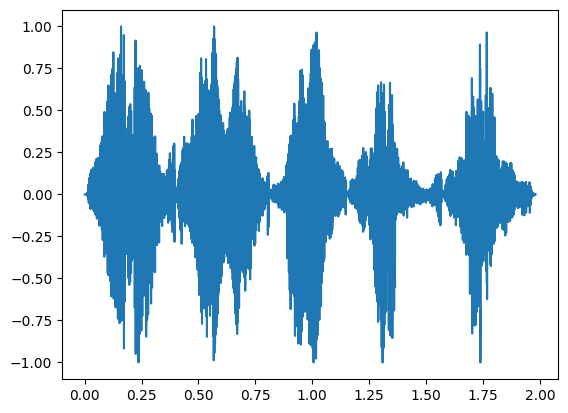

In [120]:
import  matplotlib.pyplot as plt
final_wave = modify(merge_waves(filtered_letters), 0.6)
display(final_wave.make_audio())
final_wave.plot()
plt.show()

In [122]:
## save the result
final_wave.write('generated_ayhem.wav')

Writing generated_ayhem.wav
